In [23]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### References : 

1. https://huggingface.co/learn/nlp-course/chapter7/7 

2. https://discuss.huggingface.co/t/keyerror-eval-loss-when-using-trainer-with-bertforqa/1920/3

3. https://gndp.medium.com/an-effective-eval-strategy-for-huggingface-trainer-213ae3c7144c

4. https://huggingface.co/docs/transformers/v4.49.0/en/main_classes/trainer#transformers.TrainingArguments



In [25]:
import collections
import numpy as np
import torch
import transformers
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, TrainingArguments, Trainer
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


In [6]:
raw_datasets = load_dataset("squad_v2")

train_size = 15000
raw_datasets["train"] = raw_datasets["train"].select(range(train_size))


README.md:   0%|          | 0.00/8.92k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/16.4M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.35M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/130319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11873 [00:00<?, ? examples/s]

#### SpanBert Finetune

In [ ]:
max_length = 384
stride = 128

tokenizer = AutoTokenizer.from_pretrained("SpanBERT/spanbert-base-cased")

''' 
Preporcessing the training data
'''

def preprocess_training_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]

        if len(answer["text"]) == 0:
            start_positions.append(0)
            end_positions.append(0)
            continue

        start_char = answer["answer_start"][0]
        end_char = start_char + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs



train_dataset = raw_datasets["train"].map(
    preprocess_training_examples,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
)


config.json:   0%|          | 0.00/413 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

In [ ]:
''' 
Preporcessing the validation data
'''


def preprocess_validation_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,  # Ensure offset_mapping is returned
        padding="max_length",
    )

    # Checking if offset_mapping is in inputs
    if "offset_mapping" not in inputs:
        raise ValueError("Tokenizer did not return offset_mapping. Check tokenizer settings.")

    offset_mapping = inputs["offset_mapping"]
    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []
    start_positions = []
    end_positions = []
    answers = examples["answers"]

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offsets_cleaned = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]
        inputs["offset_mapping"][i] = offsets_cleaned

        answer = answers[sample_idx]
        if len(answer["answer_start"]) == 0:
            # No answer case
            start_positions.append(0)
            end_positions.append(0)
        else:
            start_char = answer["answer_start"][0]
            end_char = answer["answer_start"][0] + len(answer["text"][0])

        
            idx = 0
            while sequence_ids[idx] != 1:
                idx += 1
            context_start = idx
            while idx < len(sequence_ids) and sequence_ids[idx] == 1:
                idx += 1
            context_end = idx - 1

            # If the answer is outside the context, assigning (0,0)
            if offsets_cleaned[context_start][0] > start_char or offsets_cleaned[context_end][1] < end_char:
                start_positions.append(0)
                end_positions.append(0)
            else:
              
                idx = context_start
                while idx <= context_end and offsets_cleaned[idx][0] <= start_char:
                    idx += 1
                start_positions.append(idx - 1)

                idx = context_end
                while idx >= context_start and offsets_cleaned[idx][1] >= end_char:
                    idx -= 1
                end_positions.append(idx + 1)

    inputs["example_id"] = example_ids
    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [11]:
validation_dataset = raw_datasets["validation"].map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=raw_datasets["validation"].column_names,
)


Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

In [12]:
model = AutoModelForQuestionAnswering.from_pretrained("SpanBERT/spanbert-base-cased")

pytorch_model.bin:   0%|          | 0.00/215M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at SpanBERT/spanbert-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
''' 
Training arguments
'''

training_args = TrainingArguments(
    output_dir= "./spanbert-finetuned-squad",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    # logging_steps=1,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=6,
    weight_decay=0.01,
    report_to="none"
)

In [28]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    tokenizer=tokenizer,
)

<ipython-input-28-cd2e227fd4d0>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [29]:
trainer.can_return_loss = True

In [30]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,1.363700,2.097396
2,1.036900,2.294517
3,0.789500,2.241175
4,0.645000,2.979806
5,0.541200,3.270980
6,0.487400,3.447168


TrainOutput(global_step=11472, training_loss=0.8106186093978137, metrics={'train_runtime': 4818.7135, 'train_samples_per_second': 19.037, 'train_steps_per_second': 2.381, 'total_flos': 1.7977347511815168e+16, 'train_loss': 0.8106186093978137, 'epoch': 6.0})

In [ ]:
''' 
postprocess predictions
'''


def postprocess_predictions(examples, features, start_logits, end_logits, n_best=20, max_answer_length=30):
    example_to_features = collections.defaultdict(list)
    for idx, feature in enumerate(features):
        example_to_features[feature["example_id"]].append(idx)

    predicted_answers = []
    
    for example in examples:
        example_id = example["id"]
        context = example["context"]
        answers = []

        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]

            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()

            for start_index in start_indexes:
                for end_index in end_indexes:
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    answer_text = context[offsets[start_index][0] : offsets[end_index][1]]
                    logit_score = start_logit[start_index] + end_logit[end_index]

                    answers.append({"text": answer_text, "logit_score": logit_score})

        best_answer = max(answers, key=lambda x: x["logit_score"]) if answers else {"text": ""}
        predicted_answers.append({"id": example_id, "prediction_text": best_answer["text"]})

    return predicted_answers


In [32]:
def exact_match_score(predictions, references):
    assert len(predictions) == len(references), "Lists must have the same length"
    matches = sum(p == r for p, r in zip(predictions, references))
    return matches / len(references) * 100
val_set = raw_datasets["validation"]
predicted_answers = postprocess_predictions(val_set, validation_dataset, trainer.predict(validation_dataset).predictions[0], trainer.predict(validation_dataset).predictions[1])
theoretical_answers = [{"id": ex["id"], "answers": ex["answers"]} for ex in val_set]

In [ ]:

filtered_predictions = []
filtered_references = []

for pred, ref in zip(predicted_answers, theoretical_answers):
    if ref["answers"]["text"]: 
        filtered_predictions.append(pred["prediction_text"])
        filtered_references.append(ref["answers"]["text"][0])

em_score = exact_match_score(filtered_predictions, filtered_references)

print(f"Exact Match Score: {em_score:.2f}%")

Exact Match Score: 53.63%


In [ ]:
#Saving  the Model
trainer.save_model("./spanbert-finetuned")
loaded_model = AutoModelForQuestionAnswering.from_pretrained("./spanbert-finetuned")
loaded_trainer = Trainer(model=loaded_model, args=training_args, tokenizer=tokenizer,eval_dataset=validation_dataset)

predicted_answers = postprocess_predictions(
    val_set, validation_dataset,
    loaded_trainer.predict(validation_dataset).predictions[0],
    loaded_trainer.predict(validation_dataset).predictions[1]
)

filtered_predictions = []
filtered_references = []

for pred, ref in zip(predicted_answers, theoretical_answers):
    if ref["answers"]["text"]:  
        filtered_predictions.append(pred["prediction_text"])
        filtered_references.append(ref["answers"]["text"][0])

em_score = exact_match_score(filtered_predictions, filtered_references)

print(f"Exact Match Score: {em_score:.2f}%")


<ipython-input-35-79e500c069f1>:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  loaded_trainer = Trainer(model=loaded_model, args=training_args, tokenizer=tokenizer,eval_dataset=validation_dataset)


Exact Match Score: 53.63%


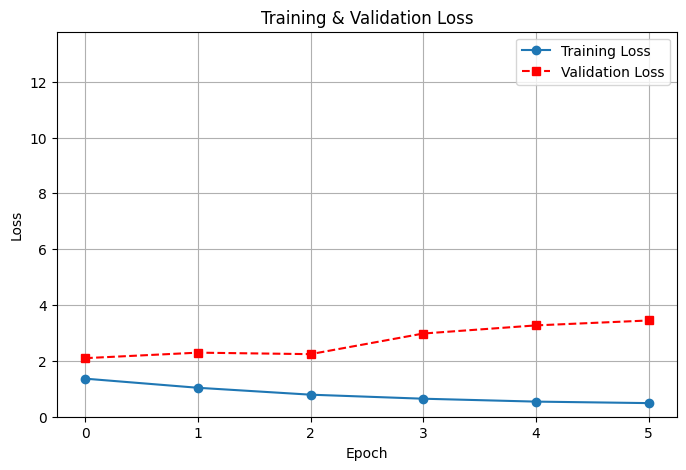

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_loss(trainer_obj):
   
    train_loss = [x["loss"] for x in trainer_obj.state.log_history if "loss" in x]
    validation_loss = [x["eval_loss"] for x in trainer_obj.state.log_history if "eval_loss" in x]
    
    plt.figure(figsize=(8, 5))
    plt.plot(train_loss, label="Training Loss", marker='o', linestyle='-')
    plt.plot(validation_loss, label="Validation Loss", marker='s', linestyle='--', color='red')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training & Validation Loss")
    plt.grid()

    plt.ylim(0, max(max(train_loss), max(validation_loss)) *4)

    plt.show()

plot_loss(trainer)


In [38]:
!zip -r spanbert.zip /kaggle/working/spanbert-finetuned

  adding: kaggle/working/spanbert-finetuned/ (stored 0%)
  adding: kaggle/working/spanbert-finetuned/vocab.txt (deflated 49%)
  adding: kaggle/working/spanbert-finetuned/tokenizer_config.json (deflated 74%)
  adding: kaggle/working/spanbert-finetuned/tokenizer.json (deflated 70%)
  adding: kaggle/working/spanbert-finetuned/training_args.bin (deflated 51%)
  adding: kaggle/working/spanbert-finetuned/model.safetensors (deflated 10%)
  adding: kaggle/working/spanbert-finetuned/config.json (deflated 47%)
  adding: kaggle/working/spanbert-finetuned/special_tokens_map.json (deflated 42%)


In [39]:
from IPython.display import FileLink
FileLink(r'spanbert.zip')

/kaggle/working/spanbert.zip

### Spanbert CRF

In [1]:
pip install pytorch-crf

Note: you may need to restart the kernel to use updated packages.


In [ ]:

import collections
import numpy as np
import torch
import torch.nn as nn
from torchcrf import CRF
from transformers import (
    AutoTokenizer,
    Trainer,
    TrainingArguments,
    AutoConfig,
    BertPreTrainedModel,
    AutoModel,
)
import matplotlib.pyplot as plt
from datasets import load_dataset
from tqdm.auto import tqdm

# Hyperparameters
max_length = 384
stride = 128

tokenizer = AutoTokenizer.from_pretrained("SpanBERT/spanbert-base-cased")

def preprocess_training_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )
    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]

        # Handling unanswerable cases
        if len(answer["text"]) == 0:
            start_positions.append(0)
            end_positions.append(0)
            continue

        start_char = answer["answer_start"][0]
        end_char = start_char + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while idx < len(sequence_ids) and sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    # Creating token-level labels for CRF: 0 = O, 1 = B-ANSWER, 2 = I-ANSWER
    labels = []
    for sp, ep in zip(start_positions, end_positions):
        label_seq = [0] * max_length
        if sp != 0 or ep != 0:
            label_seq[sp] = 1  # B-ANSWER
            for j in range(sp + 1, ep + 1):
                label_seq[j] = 2  # I-ANSWER
        labels.append(label_seq)

    inputs["example_id"] = [examples["id"][sample_map[i]] for i in range(len(sample_map))]
    inputs["labels"] = labels
    inputs["offset_mapping"] = offset_mapping  # keep for postprocessing
    return inputs

# def preprocess_validation_examples(examples):
#     questions = [q.strip() for q in examples["question"]]
#     inputs = tokenizer(
#         questions,
#         examples["context"],
#         max_length=max_length,
#         truncation="only_second",
#         stride=stride,
#         return_overflowing_tokens=True,
#         return_offsets_mapping=True,
#         padding="max_length",
#     )
#     offset_mapping = inputs.pop("offset_mapping")
#     sample_map = inputs.pop("overflow_to_sample_mapping")
#     inputs["example_id"] = [examples["id"][sample_map[i]] for i in range(len(sample_map))]
#     inputs["offset_mapping"] = offset_mapping
#     return inputs

raw_datasets = load_dataset("squad_v2")


train_size= 15000
raw_datasets["train"] = raw_datasets["train"].select(range(train_size))
# raw_datasets["validation"] = raw_datasets["validation"].select(range(val_size))

train_dataset = raw_datasets["train"].map(
    preprocess_training_examples,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
)
validation_dataset = raw_datasets["validation"].map(
    preprocess_training_examples,
    batched=True,
    remove_columns=raw_datasets["validation"].column_names,
)

class SpanBERTCRFForQuestionAnswering(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = 3  # 0: O, 1: B-ANSWER, 2: I-ANSWER
        self.spanbert = AutoModel.from_pretrained("SpanBERT/spanbert-base-cased", config=config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, self.num_labels)
        self.crf = CRF(num_tags=self.num_labels, batch_first=True)
        self.init_weights()

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None,return_loss=True):
        outputs = self.spanbert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        sequence_output = outputs[0]  # (batch_size, seq_length, hidden_size)
        sequence_output = self.dropout(sequence_output)
        emissions = self.classifier(sequence_output)  # (batch_size, seq_length, num_labels)
        mask = attention_mask.bool()
       
        if labels is not None:
            loss = -self.crf(emissions, labels, mask=mask, reduction="mean")
            return {"loss": loss, "logits": emissions}
        else:
            # Returning logits only to decode using CRF externally.
            return {"logits": emissions}

config = AutoConfig.from_pretrained("SpanBERT/spanbert-base-cased")
model = SpanBERTCRFForQuestionAnswering(config)

# Training arguments
training_args = TrainingArguments(
    output_dir="./spanbert-crf-finetuned-squad",
    eval_strategy="epoch",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    # logging_steps=1
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=6,
    weight_decay=0.01,
    report_to="none",
    # label_names = ["start_positions","end"]
    # prediction_loss_only=False # Forces Trainer to track loss
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    tokenizer=tokenizer,
)
trainer.can_return_loss = True

trainer.train()
# for epoch in range(training_args.num_train_epochs):
#     trainer.train()
#     eval_results = trainer.evaluate()
#     print(f"Epoch {epoch+1}: Training Loss = {eval_results['loss']:.4f} , Validation Loss = {eval_results['eval_loss']:.4f}")


def postprocess_predictions(examples, features, predicted_label_sequences, max_answer_length=30):
    example_to_features = collections.defaultdict(list)
    for idx, feature in enumerate(features):
        example_to_features[feature["example_id"]].append(idx)

    predicted_answers = []
    for example in examples:
        example_id = example["id"]
        context = example["context"]
        answers = []

        for feature_index in example_to_features[example_id]:
            pred_labels = predicted_label_sequences[feature_index]  # predicted label sequence for the feature
            offsets = features[feature_index]["offset_mapping"]
            answer_text = ""

            for i, label in enumerate(pred_labels):
                if label == 1:
                    start_i = i
                    end_i = i
                    while end_i + 1 < len(pred_labels) and pred_labels[end_i + 1] == 2:
                        end_i += 1
                    if end_i - start_i + 1 <= max_answer_length:
                        if offsets[start_i] is not None and offsets[end_i] is not None:
                            answer_text = context[offsets[start_i][0]:offsets[end_i][1]]
                    break  
            answers.append(answer_text)
        best_answer = max(answers, key=len) if any(a != "" for a in answers) else ""
        predicted_answers.append({"id": example_id, "prediction_text": best_answer})
    return predicted_answers


pred_out = trainer.predict(validation_dataset)
logits = pred_out.predictions  # shape: (num_features, seq_length, num_labels)


config.json:   0%|          | 0.00/413 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/8.92k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/16.4M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.35M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/130319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11873 [00:00<?, ? examples/s]

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/215M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at SpanBERT/spanbert-base-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-2-6656e760ba08>:180: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,10.211900,7.555632
2,4.340400,6.771304
3,2.883800,8.530226
4,2.053400,9.432690
5,1.509200,10.688242
6,1.200800,10.986923


In [3]:
device = model.device
logits_tensor = torch.tensor(logits).to(device)
attention_mask = torch.tensor(validation_dataset["attention_mask"]).to(device)

# Use our model's CRF to decode predictions
predicted_label_sequences = model.crf.decode(logits_tensor, mask=attention_mask.bool())

# Use original validation examples for postprocessing (assume raw_datasets["validation"] exists)
val_set = raw_datasets["validation"]
predicted_answers = postprocess_predictions(val_set, validation_dataset, predicted_label_sequences)

# Prepare theoretical (ground truth) answers
theoretical_answers = [{"id": ex["id"], "answers": ex["answers"]} for ex in val_set]

def exact_match_score(predictions, references):
    assert len(predictions) == len(references), "Lists must have the same length"
    matches = sum(p == r for p, r in zip(predictions, references))
    return matches / len(references) * 100

# em_score = exact_match_score(
#     [p["prediction_text"] for p in predicted_answers],
#     [r["answers"]["text"][0] if r["answers"]["text"] else "" for r in theoretical_answers],
# )
# # Ensure we compare only against answerable references


# print(f"Exact Match Score: {em_score:.2f}%")
filtered_predictions = []
filtered_references = []

for pred, ref in zip(predicted_answers, theoretical_answers):
    if ref["answers"]["text"]:  # Only include if there's an actual answer
        filtered_predictions.append(pred["prediction_text"])
        filtered_references.append(ref["answers"]["text"][0])

# Calculate Exact Match Score
em_score = exact_match_score(filtered_predictions, filtered_references)
print(f"Exact Match Score: {em_score:.2f}%")

Exact Match Score: 46.86%


In [ ]:
trainer.save_model("./spanbert-crf-finetuned")

In [ ]:
from transformers import AutoTokenizer, Trainer
import torch
from collections import defaultdict

tokenizer = AutoTokenizer.from_pretrained("SpanBERT/spanbert-base-cased")
model = SpanBERTCRFForQuestionAnswering.from_pretrained("./spanbert-crf-finetuned")

# Load the validation dataset and preprocess it
# validation_dataset = raw_datasets["validation"].map(
#     preprocess_training_examples,
#     batched=True,
#     remove_columns=raw_datasets["validation"].column_names,
# )


training_args = TrainingArguments(
    output_dir="./spanbert-crf-finetuned-squad",
    per_device_eval_batch_size=8,
    report_to="none", 
)

trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=validation_dataset,
    tokenizer=tokenizer,
)


pred_out = trainer.predict(validation_dataset)
logits = pred_out.predictions  # shape: (num_features, seq_length, num_labels)


attention_mask = torch.tensor(validation_dataset["attention_mask"]).to(model.device)
logits_tensor = torch.tensor(logits).to(model.device)
predicted_label_sequences = model.crf.decode(logits_tensor, mask=attention_mask.bool())

# Postprocess predictions
predicted_answers = postprocess_predictions(raw_datasets["validation"], validation_dataset, predicted_label_sequences)

theoretical_answers = [{"id": ex["id"], "answers": ex["answers"]} for ex in raw_datasets["validation"]]

filtered_predictions = []
filtered_references = []

for pred, ref in zip(predicted_answers, theoretical_answers):
    if ref["answers"]["text"]: 
        filtered_predictions.append(pred["prediction_text"])
        filtered_references.append(ref["answers"]["text"][0])


def exact_match_score(predictions, references):
    assert len(predictions) == len(references), "Lists must have the same length"
    matches = sum(p == r for p, r in zip(predictions, references))
    return matches / len(references) * 100


em_score = exact_match_score(filtered_predictions, filtered_references)
print(f"Exact Match Score: {em_score:.2f}%")


Some weights of BertModel were not initialized from the model checkpoint at SpanBERT/spanbert-base-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-10-b2bc45a6f3e8>:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Exact Match Score: 46.86%


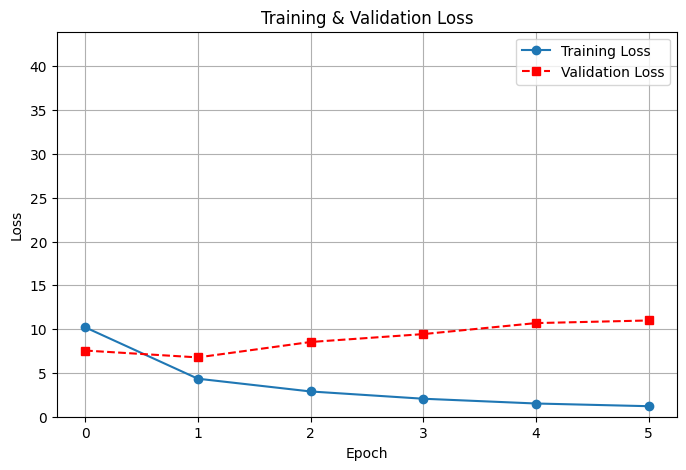

In [ ]:
def plot_loss(trainer_obj):
    train_loss = [x["loss"] for x in trainer_obj.state.log_history if "loss" in x]
    validation_loss = [x["eval_loss"] for x in trainer_obj.state.log_history if "eval_loss" in x]

   
    plt.figure(figsize=(8, 5))
    plt.plot(train_loss, label="Training Loss", marker='o', linestyle='-')
    plt.plot(validation_loss, label="Validation Loss", marker='s', linestyle='--', color='red')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training & Validation Loss")
    plt.grid()

    plt.ylim(0, max(max(train_loss), max(validation_loss)) *4)

    plt.show()


plot_loss(trainer)

In [7]:
!zip -r spanbert_crf.zip /kaggle/working/spanbert-crf-finetuned

  adding: kaggle/working/spanbert-crf-finetuned/ (stored 0%)
  adding: kaggle/working/spanbert-crf-finetuned/training_args.bin (deflated 51%)
  adding: kaggle/working/spanbert-crf-finetuned/special_tokens_map.json (deflated 42%)
  adding: kaggle/working/spanbert-crf-finetuned/vocab.txt (deflated 49%)
  adding: kaggle/working/spanbert-crf-finetuned/tokenizer.json (deflated 70%)
  adding: kaggle/working/spanbert-crf-finetuned/config.json (deflated 47%)
  adding: kaggle/working/spanbert-crf-finetuned/tokenizer_config.json (deflated 74%)
  adding: kaggle/working/spanbert-crf-finetuned/model.safetensors (deflated 9%)


In [8]:
from IPython.display import FileLink
FileLink(r'spanbert_crf.zip')

/kaggle/working/spanbert_crf.zip